# Homework 1
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers linear filters, convolution and correlation.

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import io

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

## Part 1: Convolutions
### 1.1 Commutative Property (10 points)
Recall that the convolution of an image $f:\mathbb{R}^2\rightarrow \mathbb{R}$ and a kernel $h:\mathbb{R}^2\rightarrow\mathbb{R}$ is defined as follows:
$$(f*h)[m,n]=\sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot h[m-i,n-j]$$

Or equivalently,
\begin{align*}
(f*h)[m,n] &= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty h[i,j]\cdot f[m-i,n-j]\\
&= (h*f)[m,n]
\end{align*}

Show that this is true (i.e. prove that the convolution operator is commutative: $f*h = h*f$).

**Answer:**

We can replace $i, j$ with $m-i, n-j$, and then get
\begin{align*}
(f*h)[m,n] &= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot h[m-i,n-j]\\
&= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[m-i,n-j]\cdot h[m-(m-i),n-(n-j)]\\
&= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty h[i,j]\cdot f[m-i,n-j]\\
&= (h*f)[m,n]
\end{align*}

### 1.2 Shift Invariance (10 points)
Let $f$ be a function $\mathbb{R}^2\rightarrow\mathbb{R}$. Consider a system $f\xrightarrow{s}g$, where $g=(f*h)$ with some kernel $h:\mathbb{R}^2\rightarrow\mathbb{R}$. Also consider functions $f'(m,n) = f(m-m_0, n-n_0)$ and $g'(m,n) = g(m-m_0, n-n_0)$.  

Show that $S$ defined by any kernel $h$ is a Shift Invariant system by showing that $g' = (f'*h)$.

**Answer:** 

\begin{align*}
(f'*h)[m,n] &= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f'[i,j]\cdot h[m-i,n-j]\\
&= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i-m_0,j-n_0]\cdot h[m-i,n-j]\\
&= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot h[m-m_0-i,n-n_0-j]\\
&= g[m-m_0, n-n_0]\\
&= g'[m, n]
\end{align*}

### 1.3 Implementation (30 points)

In this section, you will implement two versions of convolution:
- `conv_nested`
- `conv_fast`

First, run the code cell below to load the image to work with.

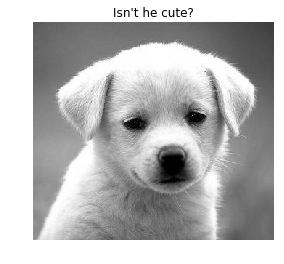

In [2]:
# Open image as grayscale
img = io.imread('dog.jpg', as_grey=True)

# Show image
plt.imshow(img)
plt.axis('off')
plt.title("Isn't he cute?")
plt.show()

Now, implement the function **`conv_nested`** in **`filters.py`**. This is a naive implementation of convolution which uses 4 nested for-loops. It takes an image $f$ and a kernel $h$ as inputs and outputs the convolved image $(f*h)$ that has the same shape as the input image. This implementation should take a few seconds to run.

*- Hint: It may be easier to implement $(h*f)$*

We'll first test your `conv_nested` function on a simple input.

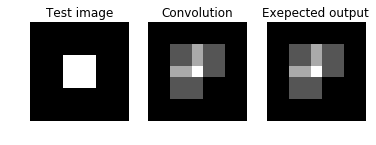

In [3]:
from filters import conv_nested

# Simple convolution kernel.
kernel = np.array(
[
    [1,0,1],
    [0,0,0],
    [1,0,0]
])

# Create a test image: a white square in the middle
test_img = np.zeros((9, 9))
test_img[3:6, 3:6] = 1

# Run your conv_nested function on the test image
test_output = conv_nested(test_img, kernel)

# Build the expected output
expected_output = np.zeros((9, 9))
expected_output[2:7, 2:7] = 1
expected_output[5:, 5:] = 0
expected_output[4, 2:5] = 2
expected_output[2:5, 4] = 2
expected_output[4, 4] = 3

# Plot the test image
plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title('Test image')
plt.axis('off')

# Plot your convolved image
plt.subplot(1,3,2)
plt.imshow(test_output)
plt.title('Convolution')
plt.axis('off')

# Plot the exepected output
plt.subplot(1,3,3)
plt.imshow(expected_output)
plt.title('Exepected output')
plt.axis('off')
plt.show()

# Test if the output matches expected output
assert np.max(test_output - expected_output) < 1e-10, "Your solution is not correct."

Now let's test your `conv_nested` function on a real image.

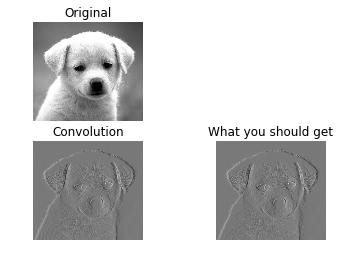

In [4]:
from filters import conv_nested

# Simple convolution kernel.
# Feel free to change the kernel to see different outputs.
kernel = np.array(
[
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])

out = conv_nested(img, kernel)

# Plot original image
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Plot your convolved image
plt.subplot(2,2,3)
plt.imshow(out)
plt.title('Convolution')
plt.axis('off')

# Plot what you should get
solution_img = io.imread('convoluted_dog.jpg', as_grey=True)
plt.subplot(2,2,4)
plt.imshow(solution_img)
plt.title('What you should get')
plt.axis('off')

plt.show()

Let us implement a more efficient version of convolution using array operations in numpy. As shown in the lecture, a convolution can be considered as a sliding window that computes sum of the pixel values weighted by the flipped kernel. The faster version will i) zero-pad an image, ii) flip the kernel horizontally and vertically, and iii) compute weighted sum of the neighborhood at each pixel.

First, implement the function **`zero_pad`** in **`filters.py`**.


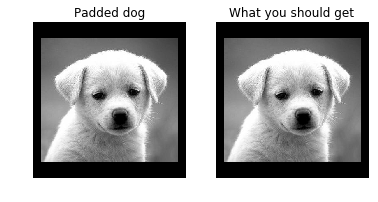

In [5]:
from filters import zero_pad

pad_width = 20 # width of the padding on the left and right
pad_height = 40 # height of the padding on the top and bottom

padded_img = zero_pad(img, pad_height, pad_width)

# Plot your padded dog
plt.subplot(1,2,1)
plt.imshow(padded_img)
plt.title('Padded dog')
plt.axis('off')

# Plot what you should get
solution_img = io.imread('padded_dog.jpg', as_grey=True)
plt.subplot(1,2,2)
plt.imshow(solution_img)
plt.title('What you should get')
plt.axis('off')

plt.show()

Next, complete the function **`conv_fast`** in **`filters.py`** using `zero_pad`. Run the code below to compare the outputs by the two implementations. `conv_fast` should run significantly faster than `conv_nested`.  
Depending on your implementation and computer, `conv_nested` should take a few seconds and `conv_fast` should be around 5 times faster.

conv_nested: took 1.719207 seconds.
conv_fast: took 0.390108 seconds.


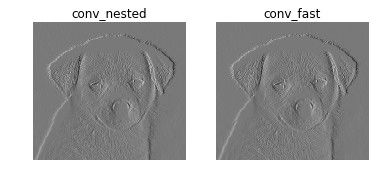

In [6]:
from filters import conv_fast

t0 = time()
out_fast = conv_fast(img, kernel)
t1 = time()
out_nested = conv_nested(img, kernel)
t2 = time()

# Compare the running time of the two implementations
print("conv_nested: took %f seconds." % (t2 - t1))
print("conv_fast: took %f seconds." % (t1 - t0))

# Plot conv_nested output
plt.subplot(1,2,1)
plt.imshow(out_nested)
plt.title('conv_nested')
plt.axis('off')

# Plot conv_fast output
plt.subplot(1,2,2)
plt.imshow(out_fast)
plt.title('conv_fast')
plt.axis('off')

# Make sure that the two outputs are the same
if not (np.max(out_fast - out_nested) < 1e-10):
    print("Different outputs! Check your implementation.")

### Extra Credit 1 (10 points)
Devise a faster version of convolution and implement **`conv_faster`** in **`filters.py`**. You will earn extra credit only if the `conv_faster` runs faster (by a fair margin) than `conv_fast` **and** outputs the same result.

conv_fast: took 0.373095 seconds.
conv_faster: took 0.002424 seconds.


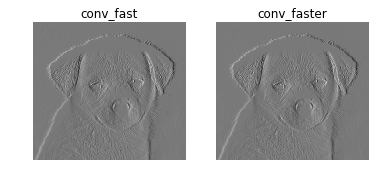

In [7]:
from filters import conv_faster

t0 = time()
out_fast = conv_fast(img, kernel)
t1 = time()
out_faster = conv_faster(img, kernel)
t2 = time()

# Compare the running time of the two implementations
print("conv_fast: took %f seconds." % (t1 - t0))
print("conv_faster: took %f seconds." % (t2 - t1))

# Plot conv_nested output
plt.subplot(1,2,1)
plt.imshow(out_fast)
plt.title('conv_fast')
plt.axis('off')

# Plot conv_fast output
plt.subplot(1,2,2)
plt.imshow(out_faster)
plt.title('conv_faster')
plt.axis('off')

# Make sure that the two outputs are the same
if not (np.max(out_fast - out_faster) < 1e-10):
    print("Different outputs! Check your implementation.")

---
## Part 2: Cross-correlation

Cross-correlation of two 2D signals $f$ and $g$ is defined as follows:
$$(f\star{g})[m,n]=\sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot g[i-m,j-n]$$

### 2.1 Template Matching with Cross-correlation (12 points)
Suppose that you are a clerk at a grocery store. One of your responsibilites is to check the shelves periodically and stock them up whenever there are sold-out items. You got tired of this laborious task and decided to build a computer vision system that keeps track of the items on the shelf.

Luckily, you have learned in CS131 that cross-correlation can be used for template matching: a template $g$ is multiplied with regions of a larger image $f$ to measure how similar each region is to the template.

The template of a product (`template.jpg`) and the image of shelf (`shelf.jpg`) is provided. We will use cross-correlation to find the product in the shelf.

Implement **`cross_correlation`** function in **`filters.py`** and run the code below.

*- Hint: you may use the `conv_fast` function you implemented in the previous question.*

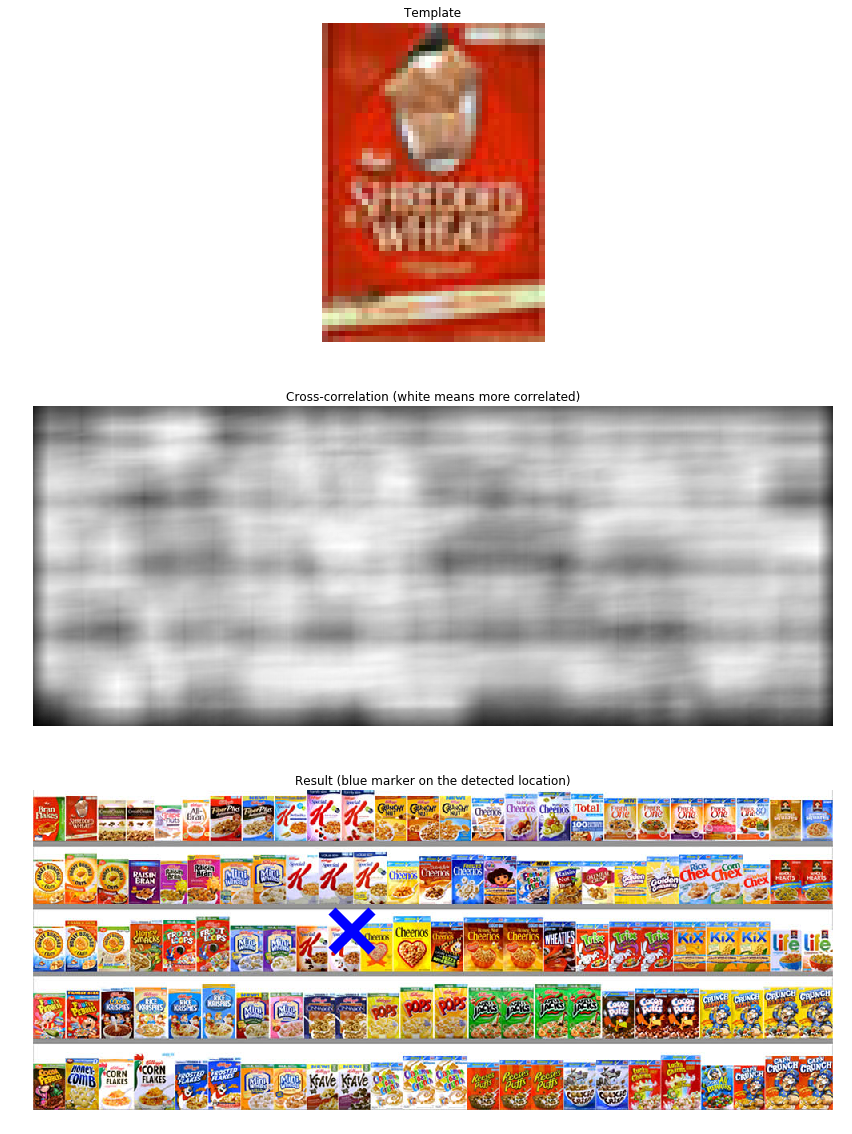

In [8]:
from filters import cross_correlation

# Load template and image in grayscale
img = io.imread('shelf.jpg')
img_grey = io.imread('shelf.jpg', as_grey=True)
temp = io.imread('template.jpg')
temp_grey = io.imread('template.jpg', as_grey=True)

# Perform cross-correlation between the image and the template
out = cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display product template
plt.figure(figsize=(25,20))
plt.subplot(3, 1, 1)
plt.imshow(temp)
plt.title('Template')
plt.axis('off')

# Display cross-correlation output
plt.subplot(3, 1, 2)
plt.imshow(out)
plt.title('Cross-correlation (white means more correlated)')
plt.axis('off')

# Display image
plt.subplot(3, 1, 3)
plt.imshow(img)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw marker at detected location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()


#### Interpretation
How does the output of cross-correlation filter look? Was it able to detect the product correctly? Explain what problems there might be with using a raw template as a filter.

**Answer:** Blurred pattern appeared in the output of cross-correlation filter; the correlation at white areas is higher. It wasn't able to detect the product correctly. The correlation at white areas is higher; the object in the image might have different size with the raw template.

---
### 2.2 Zero-mean cross-correlation (6 points)
A solution to this problem is to subtract the mean value of the template so that it has zero mean.

Implement **`zero_mean_cross_correlation`** function in **`filters.py`** and run the code below.

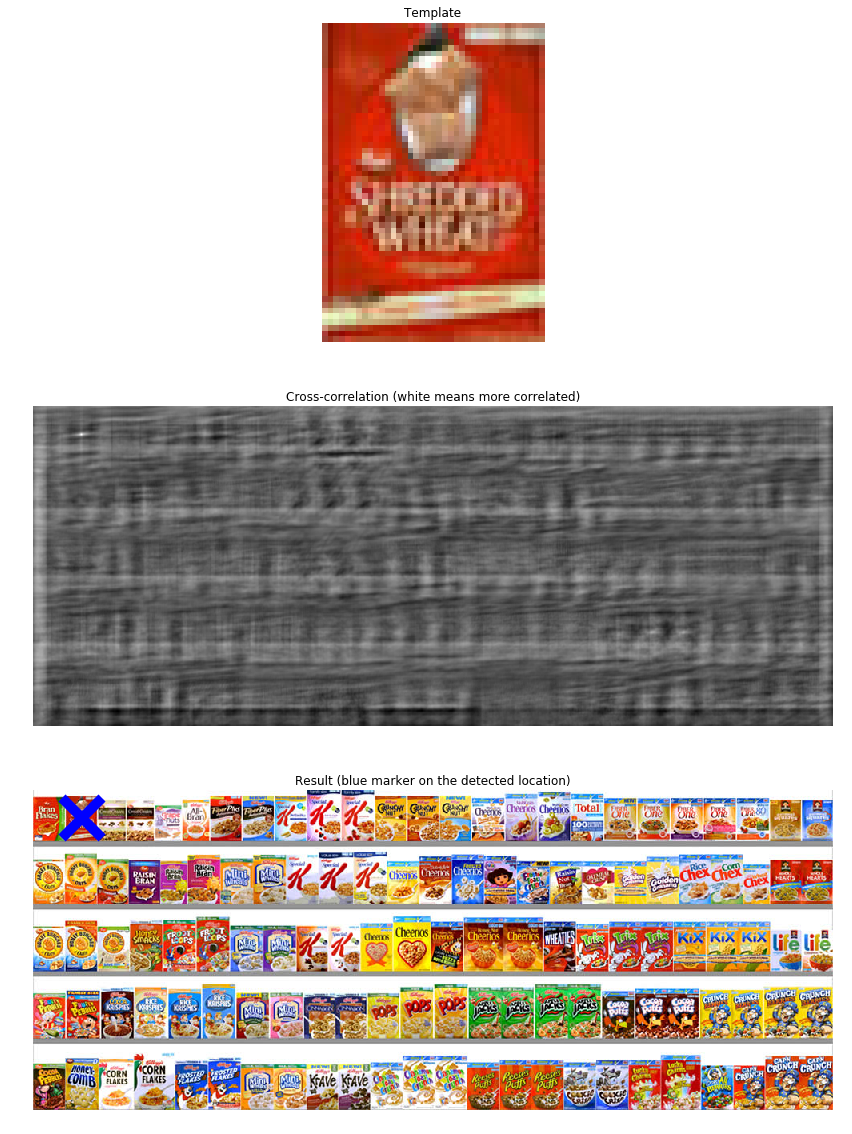

In [9]:
from filters import zero_mean_cross_correlation

# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display product template
plt.figure(figsize=(30,20))
plt.subplot(3, 1, 1)
plt.imshow(temp)
plt.title('Template')
plt.axis('off')

# Display cross-correlation output
plt.subplot(3, 1, 2)
plt.imshow(out)
plt.title('Cross-correlation (white means more correlated)')
plt.axis('off')

# Display image
plt.subplot(3, 1, 3)
plt.imshow(img)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()


You can also determine whether the product is present with appropriate scaling and thresholding.

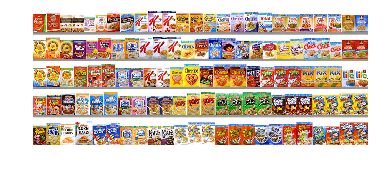

The product is on the shelf


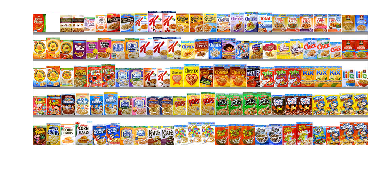

The product is not on the shelf


In [10]:
def check_product_on_shelf(shelf, product):
    out = zero_mean_cross_correlation(shelf, product)
    
    # Scale output by the size of the template
    out = out / float(product.shape[0]*product.shape[1])
    
    # Threshold output (this is arbitrary, you would need to tune the threshold for a real application)
    out = out > 0.025
    
    if np.sum(out) > 0:
        print('The product is on the shelf')
    else:
        print('The product is not on the shelf')

# Load image of the shelf without the product
img2 = io.imread('shelf_soldout.jpg')
img2_grey = io.imread('shelf_soldout.jpg', as_grey=True)

plt.imshow(img)
plt.axis('off')
plt.show()
check_product_on_shelf(img_grey, temp_grey)

plt.imshow(img2)
plt.axis('off')
plt.show()
check_product_on_shelf(img2_grey, temp_grey)

---
### 2.3 Normalized Cross-correlation (12 points)
One day the light near the shelf goes out and the product tracker starts to malfunction. The `zero_mean_cross_correlation` is not robust to change in lighting condition. The code below demonstrates this.

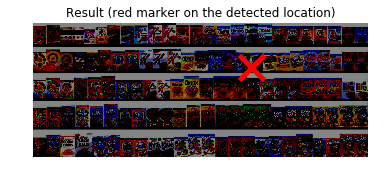

In [11]:
from filters import normalized_cross_correlation

# Load image
img = io.imread('shelf_dark.jpg')
img_grey = io.imread('shelf_dark.jpg', as_grey=True)

# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display image
plt.imshow(img)
plt.title('Result (red marker on the detected location)')
plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'rx', ms=25, mew=5)
plt.show()

A solution is to normalize the pixels of the image and template at every step before comparing them. This is called **normalized cross-correlation**.

The mathematical definition for normalized cross-correlation of $f$ and template $g$ is:
$$(f\star{g})[m,n]=\sum_{i,j} \frac{f[i,j]-\overline{f_{m,n}}}{\sigma_{f_{m,n}}} \cdot \frac{g[i-m,j-n]-\overline{g}}{\sigma_g}$$

where:
- $f_{m,n}$ is the patch image at position $(m,n)$
- $\overline{f_{m,n}}$ is the mean of the patch image $f_{m,n}$
- $\sigma_{f_{m,n}}$ is the standard deviation of the patch image $f_{m,n}$ 
- $\overline{g}$ is the mean of the template $g$
- $\sigma_g$ is the standard deviation of the template $g$

Implement **`normalized_cross_correlation`** function in **`filters.py`** and run the code below.

/home/weidong/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


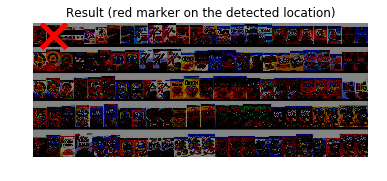

In [12]:
from filters import normalized_cross_correlation

# Perform normalized cross-correlation between the image and the template
out = normalized_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display image
plt.imshow(img)
plt.title('Result (red marker on the detected location)')
plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'rx', ms=25, mew=5)
plt.show()

## Part 3: Separable Filters

### 3.1 Theory (10 points)
Consider an $M_1\times{N_1}$ image $I$ and an $M_2\times{N_2}$ filter $F$. A filter $F$ is **separable** if it can be written as a product of two 1D filters: $F=F_1F_2$.

For example,
$$F=
\begin{bmatrix}
1 & -1 \\
1 & -1
\end{bmatrix}
$$
can be written as a matrix product of
$$F_1=
\begin{bmatrix}
1  \\
1
\end{bmatrix},
F_2=
\begin{bmatrix}
1 & -1
\end{bmatrix}
$$
Therefore $F$ is a separable filter.

Prove that for any separable filter $F=F_1F_2$,
$$I*F=(I*F_1)*F_2$$

**Answer:** 

\begin{align*}
(I*F)[m,n] &= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty I[i,j]\cdot F[m-i,n-j]\\
&= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty I[i,j]\cdot F_1[m-i]\cdot F_2[n-j]\\
&= \sum_{j=-\infty}^\infty \left(\sum_{i=-\infty}^\infty I[i,j]\cdot F_1[m-i]\right)\cdot F_2[n-j]\\
&= (I * F_1) * F_2 [m,n]
\end{align*}

### 3.2 Complexity comparison (10 points)
Consider an $M_1\times{N_1}$ image $I$ and an $M_2\times{N_2}$ filter $F$ that is separable (i.e. $F=F_1F_2$).

(i) How many multiplication operations do you need to do a direct 2D convolution (i.e. $I*F$)?<br>
(ii) How many multiplication operations do you need to do 1D convolutions on rows and columns (i.e. $(I*F_1)*F_2$)?<br>
(iii) Use Big-O notation to argue which one is more efficient in general: direct 2D convolution or two successive 1D convolutions?

**Your Answer:** 

(i) $M_1N_1M_2N_2$

(ii) $(M_1 + N_1) M_2 N_2$

(iii) Two successive 1D convolution is more efficient than direct 2D convolution, since the time complexity is $O((M_1 + N_1) M_2 N_2)$ vs $O(M_1N_1M_2N_2)$.

Now, we will empirically compare the running time of a separable 2D convolution and its equivalent two 1D convolutions. The Gaussian kernel, widely used for blurring images, is one example of a separable filter. Run the code below to see its effect.

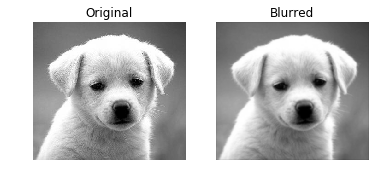

In [13]:
# Load image
img = io.imread('dog.jpg', as_grey=True)

# 5x5 Gaussian blur
kernel = np.array(
[
    [1,4,6,4,1],
    [4,16,24,16,4],
    [6,24,36,24,6],
    [4,16,24,16,4],
    [1,4,6,4,1]
])

t0 = time()
out = conv_nested(img, kernel)
t1 = time()
t_normal = t1 - t0

# Plot original image
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Plot convolved image
plt.subplot(1,2,2)
plt.imshow(out)
plt.title('Blurred')
plt.axis('off')

plt.show()

In the below code cell, define the two 1D arrays (`k1` and `k2`) whose product is equal to the Gaussian kernel.

In [14]:
# The kernel can be written as outer product of two 1D filters
k1 = None  # shape (5, 1)
k2 = None  # shape (1, 5)

### YOUR CODE HERE
k1 = np.array([0.06136, 0.24477, 0.38774, 0.24477, 0.06136]).reshape(5, 1)
k2 = np.array([0.06136, 0.24477, 0.38774, 0.24477, 0.06136]).reshape(1, 5)
### END YOUR CODE

# Check if kernel is product of k1 and k2
if not  np.all(k1 * k2 == kernel):
    print('k1 * k2 is not equal to kernel')
    
assert k1.shape == (5, 1), "k1 should have shape (5, 1)"
assert k2.shape == (1, 5), "k2 should have shape (1, 5)"

k1 * k2 is not equal to kernel


We now apply the two versions of convolution to the same image, and compare their running time. Note that the outputs of the two convolutions must be the same.

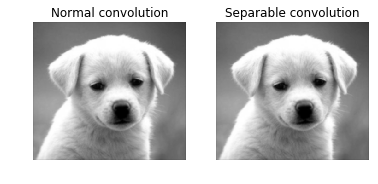

Normal convolution: took 4.569258 seconds.
Separable convolution: took 0.611439 seconds.


In [15]:
# Perform two convolutions using k1 and k2
t0 = time()
out_separable = conv_nested(img, k1)
out_separable = conv_nested(out_separable, k2)
t1 = time()
t_separable = t1 - t0

# Plot normal convolution image
plt.subplot(1,2,1)
plt.imshow(out)
plt.title('Normal convolution')
plt.axis('off')

# Plot separable convolution image
plt.subplot(1,2,2)
plt.imshow(out_separable)
plt.title('Separable convolution')
plt.axis('off')

plt.show()

print("Normal convolution: took %f seconds." % (t_normal))
print("Separable convolution: took %f seconds." % (t_separable))

In [16]:
# Check if the two outputs are equal
assert np.max(out_separable - out) < 1e-10